The goal of this notebook is to make some sort of plot that shows where in the sgRNA the SNPs are for the ancestry-associated genes

In [1]:
#Set up the environment
library(tidyverse)
library(reshape2)

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘reshape2’


The following object is masked from ‘package:tidyr’:

    smiths




I think this is a good structure for what I should do:

1) Get all the ancestry-associated genes
2) Map CCLE SNPs to those guides
3) Make a plot where each sgRNA is on its own row, and sgrna#1, sgrna#2, sgrna#3, and sgrna#4 are all on their own columns. sgrnas with most snps on the right.
4) split into two chunks: bottom have at least one SNP, top have no SNPs.

In [145]:
#Load in the ancestry association dataset from "New_Ancestry_Associated_Dependencies"
setwd('/home/jupyter/Ancestry/ccle_ancestry_analysis')
ancestry.associations = read.table("ancestry.associated.gene.associations.txt", sep = "\t", header = T)

#Get a list of all ancestry-associated genes
ancestry.associated.genes = ancestry.associations %>%
filter(FDR <= 0.05) %>%
pull(gene) %>%
unique()


head(ancestry.associations)
ancestry.associated.genes

,gene,pval,difference,ancestry,FDR
,<chr>,<dbl>,<dbl>,<chr>,<dbl>
1,A1BG,0.07711508,2.518554e-02,AFR,0.8262291
2,A1CF,0.01553919,-4.901242e-02,AFR,0.7595784
3,A2M,0.82128228,7.297617e-05,AFR,0.9772673
4,A2ML1,0.66475156,-3.257814e-03,AFR,0.9476137
5,A3GALT2,0.89568474,-7.670531e-04,AFR,0.9866895
6,A4GALT,0.52781139,1.452687e-02,AFR,0.9160914


[1] "EEF2"      "NUP133"    "RESP18"    "ACAN"      "ADCY3"     "BTG1"     
 [7] "C22orf31"  "C2orf80"   "CBFA2T2"   "CCDC102B"  "CCDC74B"   "CCL3"     
[13] "CEP19"     "CHGB"      "CLSPN"     "COX6B1"    "DCN"       "DDX47"    
[19] "DND1"      "ECD"       "EGFR"      "FAM25A"    "FCGR3A"    "FRG2C"    
[25] "GLYCTK"    "GRB2"      "GTPBP3"    "HCN2"      "HINT3"     "HIST1H2AA"
[31] "HLA"       "HNF1B"     "INCENP"    "ITGA3"     "ITIH3"     "KIAA2013" 
[37] "KRTAP3"    "MATR3"     "MRTO4"     "MYH11"     "NAA40"     "NIT2"     
[43] "NKAIN4"    "NOP56"     "NPEPPS"    "NPHS1"     "PDXDC1"    "PEX11A"   
[49] "PTPN11"    "QRICH2"    "RAB21"     "RETNLB"    "RHD"       "RIMS2"    
[55] "RPL3"      "RPS5"      "RTP5"      "SART1"     "SCN5A"     "SLC10A5"  
[61] "SLC35B2"   "SLC38A7"   "SLC5A11"   "SNAP23"    "SPATA6L"   "SRP14"    
[67] "STX4"      "STXBP3"    "TPSD1"     "TRMT61B"   "TTC4"      "TUT1"     
[73] "TXNRD1"    "UGT2B17"   "VRK1"      "WSB2"      "ZNF675"    "APEX2"    
[79] "ATRX"      "C17orf64"  "COPG1"     "CSE1L"     "DEFB108B"  "ERI1"     
[85] "FAM86C1"   "IL1RN"     "KRT14"     "LPAR6"     "MDN1"      "NOMO2"    
[91] "PCBP4"     "PSPH"      "RPP30"     "SERINC2"   "XYLT2"     "ZFP62"

The next step is to grab all of the sgRNA sequences for these genes and map CCLE SNPs to them.

In [146]:
#First, load in the sgRNA guide map so that we can get a list of all of the guides that we want to keep
setwd("/home/jupyter/Ancestry/gwas")
guide.map = read.table("internal-21q4_v9-achilles-guide-map.csv", header = T, sep = ",")

#Now subset the data frame so that it only includes the ancestry-associated genes
guides.to.keep = guide.map %>%
mutate(gene = word(gene, 1)) %>%
filter(gene %in% all_of(ancestry.associated.genes)) 
head(guides.to.keep)

dim(guides.to.keep)

,sgrna,genome_alignment,gene,n_alignments
,<chr>,<chr>,<chr>,<int>
1,AAACTTGTGCAAGCAGAAGG,chr12_91178529_+,DCN,1
2,AACAATGCCCGTTTGCTGCA,chr16_1256533_-,TPSD1,1
3,AACTACCTATGACAGTGCCG,chr1_35764597_-,CLSPN,1
4,AAGATCGTCGACATGTACAA,chr16_15823331_-,MYH11,1
5,AAGCGGAGACTGTACAGAAA,chr4_68567977_+,UGT2B17,1
6,AAGCTGCTCGATGAGAACAG,chr6_89772683_+,MDN1,1


[1] 373   4

In [237]:
#First, load in the guide map so that we can figure out which guides are on the plus or minus strand
setwd("/home/jupyter/Ancestry/gwas")
guide.map = guides.to.keep %>%
select(sgrna, genome_alignment) %>%
mutate(genome_alignment = gsub("..*_", "", genome_alignment)) %>%
rename("strand" = genome_alignment)
head(guide.map)

#Load in the Avana bed file to get positions for the ancestry-associated guides
#Also add the annotation information from guides.to.keep to the avana.bed matrix
#Also flip the start and end positions if the sgrna is on the minus strand
setwd("/home/jupyter/Ancestry/filtered_output/avana14")
avana.bed <- read.table('Avana14_filtering.bed', sep = "\t", header = F) %>%
rename("chr" = 1, "start" = 2, "end" = 3, "sgrna" = 4) %>%
inner_join(guide.map, by = "sgrna") %>%
mutate("true_start" = ifelse(strand %in% "+", start, end)) %>%
mutate("true_end" = ifelse(strand %in% "+", end, start)) %>% #This line and the line above will create two new columns to flip the start and end if the sgrna is on the minus strand
select(chr, true_start, true_end, sgrna) %>%
rename("start" = true_start) %>%
rename("end" = true_end) %>%
inner_join(guides.to.keep, by = "sgrna")

head(avana.bed)
dim(avana.bed)

#We also need to make a bed file that works for SNP filtering, since for bcftools the orientation must always have the smaller value be the start
setwd("/home/jupyter/Ancestry/filtered_output/avana14")
avana.bed.for.filtering <- read.table('Avana14_filtering.bed', sep = "\t", header = F) %>%
rename("chr" = 1, "start" = 2, "end" = 3, "sgrna" = 4) %>%
inner_join(guide.map, by = "sgrna") %>%
inner_join(guides.to.keep, by = "sgrna")

,sgrna,strand
,<chr>,<chr>
1,AAACTTGTGCAAGCAGAAGG,+
2,AACAATGCCCGTTTGCTGCA,-
3,AACTACCTATGACAGTGCCG,-
4,AAGATCGTCGACATGTACAA,-
5,AAGCGGAGACTGTACAGAAA,+
6,AAGCTGCTCGATGAGAACAG,+


,chr,start,end,sgrna,genome_alignment,gene,n_alignments
,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<int>
1,chr1,11925511,11925534,ATGGTCTCCGACCTTCTCCA,chr1_11925528_+,KIAA2013,2
2,chr1,11925765,11925788,CCAGCTGCAGGCAACGCACG,chr1_11925782_+,KIAA2013,2
3,chr1,11925965,11925988,GCCGGCACTCCAGGACCCAG,chr1_11925982_+,KIAA2013,1
4,chr1,19255984,19256007,TCTTCTCTGTGGCCAACATG,chr1_19256001_+,MRTO4,2
5,chr1,19257449,19257472,GTAGGTCAGCAAAAGGTTGA,chr1_19257466_+,MRTO4,1
6,chr1,19257450,19257473,TAGGTCAGCAAAAGGTTGAG,chr1_19257467_+,MRTO4,1


[1] 373   7

,chr,start,end,sgrna,strand,genome_alignment,gene,n_alignments
,<chr>,<int>,<dbl>,<chr>,<chr>,<chr>,<chr>,<int>
1,chr1,11925511,11925534,ATGGTCTCCGACCTTCTCCA,+,chr1_11925528_+,KIAA2013,2
2,chr1,11925765,11925788,CCAGCTGCAGGCAACGCACG,+,chr1_11925782_+,KIAA2013,2
3,chr1,11925965,11925988,GCCGGCACTCCAGGACCCAG,+,chr1_11925982_+,KIAA2013,1
4,chr1,19255984,19256007,TCTTCTCTGTGGCCAACATG,+,chr1_19256001_+,MRTO4,2
5,chr1,19257449,19257472,GTAGGTCAGCAAAAGGTTGA,+,chr1_19257466_+,MRTO4,1
6,chr1,19257450,19257473,TAGGTCAGCAAAAGGTTGAG,+,chr1_19257467_+,MRTO4,1
7,chr1,25290744,25290767,TGACAGCTTTAGGCAACCTG,+,chr1_25290761_+,RHD,1
8,chr1,31424771,31424794,CTACCGCATGTGCTTCGCCA,+,chr1_31424788_+,SERINC2,1
9,chr1,31425350,31425373,GATCCTGGTGGGCCTCACCG,+,chr1_31425367_+,SERINC2,1


[1] 373   8

Now we need to load in all of the ccle variant calls. The entire dataset is far too large, so we will need to first subset it so that it is smaller.

In [238]:
#Format avana.bed as an actual bed file, then export it
setwd("/home/jupyter/Ancestry/analysis/map_ccle_snps_to_avana_guides")
bed.for.export = avana.bed.for.filtering %>%
select(chr, start, end, sgrna)
write.table(bed.for.export, "ancestry.associated.sgrna.ranges.bed", sep = "\t", col.names = FALSE, row.names = FALSE, quote = FALSE)


#Now use bcftools to subset the big ccle snp matrix to only include SNPs in that range
system(glue::glue("
cd /home/jupyter/Ancestry/rfmix
/home/jupyter/Ancestry/software/bcftools/bcftools view -R /home/jupyter/Ancestry/analysis/map_ccle_snps_to_avana_guides/ancestry.associated.sgrna.ranges.bed split.all_chroms.maf.subset.reheader.vcf.gz -o /home/jupyter/Ancestry/analysis/map_ccle_snps_to_avana_guides/snps.in.ancestry.guides.vcf.gz -Oz
"))

In [239]:
#Now load in the subset vcf file and format it
setwd("/home/jupyter/Ancestry/analysis/map_ccle_snps_to_avana_guides")
subset.ccle.snps = read.table("snps.in.ancestry.guides.vcf.gz", sep = "\t") %>%
filter(V7 %in% "PASS") %>%
select(-V1, -V2, -V4, -V5, -V6, -V7, -V8, -V9)

#Reformat the genotyping data
subset.ccle.snps[2:ncol(subset.ccle.snps)] = apply(subset.ccle.snps[2:ncol(subset.ccle.snps)], 2, function(x){gsub(":..*", "", x) })
subset.ccle.snps[2:ncol(subset.ccle.snps)] = apply(subset.ccle.snps[2:ncol(subset.ccle.snps)], 2, function(x){gsub("0\\|0", 0, x) })
subset.ccle.snps[2:ncol(subset.ccle.snps)] = apply(subset.ccle.snps[2:ncol(subset.ccle.snps)], 2, function(x){gsub("0\\|1", 1, x) })
subset.ccle.snps[2:ncol(subset.ccle.snps)] = apply(subset.ccle.snps[2:ncol(subset.ccle.snps)], 2, function(x){gsub("1\\|0", 1, x) })
subset.ccle.snps[2:ncol(subset.ccle.snps)] = apply(subset.ccle.snps[2:ncol(subset.ccle.snps)], 2, function(x){gsub("1\\|1", 2, x) })

#Fix the SNP column
subset.ccle.snps = subset.ccle.snps %>%
separate(V3, sep = ":", into = c("chr", "pos", "ref", "alt"))

head(subset.ccle.snps)
dim(subset.ccle.snps)

,chr,pos,ref,alt,V10,V11,V12,V13,V14,V15,⋯,V994,V995,V996,V997,V998,V999,V1000,V1001,V1002,V1003
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,chr1,19257510,G,A,1,0,0,1,2,0,⋯,0,0,0,2,1,0,1,0,1,0
2,chr1,31425387,T,C,0,1,1,2,2,2,⋯,2,0,1,0,1,1,0,1,1,1
3,chr1,35760347,T,C,1,0,1,1,2,0,⋯,1,2,0,2,0,0,0,0,1,0
4,chr1,54716627,T,A,1,1,2,2,1,0,⋯,0,2,2,0,1,0,2,2,1,1
5,chr1,54722709,C,T,1,0,2,0,0,0,⋯,0,0,1,0,0,0,0,0,1,0
6,chr2,28869984,G,T,0,0,1,1,0,0,⋯,0,2,2,0,0,1,2,1,1,0


[1]  66 998

In [240]:
#For each guide in avana.bed calculate if there is a snp in the guide, then calculate the position of that SNP
snp.in.guide.list = NULL
for(i in 1:nrow(avana.bed)){
    
    #get information for the guide of interest
    guide.start = avana.bed$start[i] %>% as.numeric() #get the position of the guide
    guide.chrom = avana.bed$chr[i] #get the chromosome that the guide is on
    sgrna.barcode = avana.bed$sgrna[i] #get the barcode sequence
    
    #subset out subset.ccle.snps so that it only includes snps on that chromsome
    subset.to.chr = subset.ccle.snps %>% filter(chr %in% guide.chrom)
    
    #now calculate the differential and add it to the list outside of the loop
    snp.position = guide.start - as.numeric(subset.to.chr$pos)
    snp.in.guide.list[[i]] = snp.position
}
names(snp.in.guide.list) = avana.bed$sgrna #Then name the list with the corresponding sgrna sequence

In [241]:
#Now create a matrix where each row is a guide and each column is a position (1-20 + 3) that is coded with 0 and 1
#1 means there is a snp in that position in at least one cell line

output.matrix = NULL
for(i in 1:length(snp.in.guide.list)){
    
    snp.position.vector = snp.in.guide.list[[i]] %>% abs() #get a vector with the snp positions
    position.with.snp = intersect(snp.position.vector, 1:23) #find the snps that map to guides or the PAM sequence
    
    #now create the final vector
    final.vector = rep(0, 23)
    final.vector[position.with.snp] <- 1
    
    #save the output vector to the matrix
    output.matrix = rbind(output.matrix, final.vector)
}
output.matrix = output.matrix %>% data.frame()

In [242]:
#Export the output.matrix so that we can use it for other purposes
output.matrix.for.export = output.matrix 
row.names(output.matrix.for.export) = avana.bed$sgrna

head(output.matrix.for.export)

#Now export it
setwd("/home/jupyter/Ancestry/analysis/map_ccle_snps_to_avana_guides")
write.table(output.matrix.for.export, "ancestry_guide_snp_positions.txt", sep = "\t", row.names = TRUE, col.names = TRUE, quote = FALSE)

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,⋯,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ATGGTCTCCGACCTTCTCCA,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
CCAGCTGCAGGCAACGCACG,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
GCCGGCACTCCAGGACCCAG,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
TCTTCTCTGTGGCCAACATG,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
GTAGGTCAGCAAAAGGTTGA,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
TAGGTCAGCAAAAGGTTGAG,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


Now format the output matrix for plotting, then plot the heatmap

In [243]:
#Format the dataset for plotting a heatmap
output.matrix.for.plotting = output.matrix %>%
mutate("sgrna" = names(snp.in.guide.list), .before = 1) %>%
mutate("gene" = sgrna, .after = sgrna) %>%
mutate(gene = plyr::mapvalues(gene, from = avana.bed$sgrna, to = avana.bed$gene, warn_missing = FALSE)) %>%
select(-sgrna) %>% #remove the sgrna column
melt() %>%
group_by(gene, variable) %>%
summarise(max(value)) %>%
rename("value" = 3)

head(output.matrix.for.plotting)


#calculate the number of SNPs per gene
snps.per.gene = output.matrix.for.plotting %>%
group_by(gene) %>%
summarise(sum(value)) %>%
rename("value" = 2) %>%
arrange(-value) 



Using gene as id variables

`summarise()` has grouped output by 'gene'. You can override using the `.groups` argument.



gene,variable,value
<chr>,<fct>,<dbl>
ACAN,X1,0
ACAN,X2,0
ACAN,X3,0
ACAN,X4,0
ACAN,X5,0
ACAN,X6,0


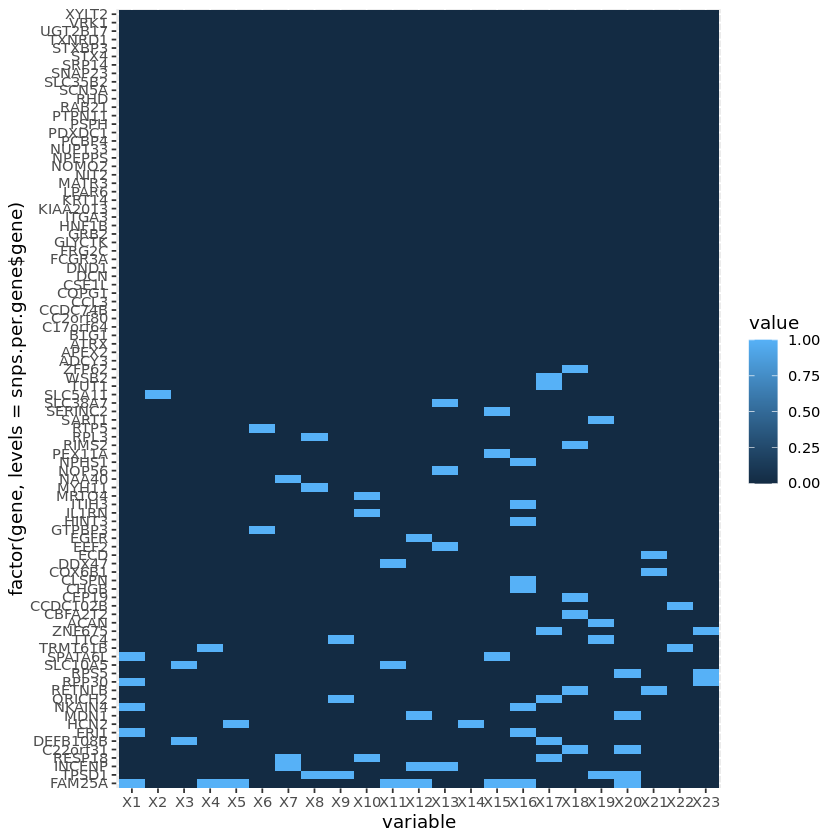

In [244]:
#Now plot the heatmap
output.matrix.for.plotting %>%
ggplot(aes(x = variable, y = factor(gene, levels = snps.per.gene$gene), fill = value)) + 
geom_tile()

#And export it to the bucket
#Export it to the google bucket
setwd('/home/jupyter/Ancestry/figures')
ggsave("ccle_snp_heatmap.pdf", width = 5, height = 5)
system(glue::glue("
cd /home/jupyter/Ancestry/figures
gsutil cp ccle_snp_heatmap.pdf gs://fc-45c0e148-0b1c-4244-9bfc-feb559bbc514
"))

Now let's calculate the CCLE ancestry fractions for the SNPs that map to guides

In [120]:
#First extract the sample names from the vcf file, then load them into R
system(glue::glue("
cd /home/jupyter/Ancestry/analysis/map_ccle_snps_to_avana_guides
/home/jupyter/Ancestry/software/bcftools/bcftools query -l /home/jupyter/Ancestry/analysis/map_ccle_snps_to_avana_guides/snps.in.ancestry.guides.vcf.gz > ccle.sample.names.txt
"))

setwd("/home/jupyter/Ancestry/analysis/map_ccle_snps_to_avana_guides")
sample.names = read.table("ccle.sample.names.txt", sep = "\t") %>%
pull(1)
head(sample.names)

[1] "ACH-000657" "ACH-000617" "ACH-000685" "ACH-000632" "ACH-000171"
[6] "ACH-000863"

In [121]:
#Format a matrix with the SNP-level data that is annotated with the cell line names
snp.level.data.matrix = subset.ccle.snps
colnames(snp.level.data.matrix) = c("chr", "pos", "ref", "alt", sample.names)
head(snp.level.data.matrix)

,chr,pos,ref,alt,ACH-000657,ACH-000617,ACH-000685,ACH-000632,ACH-000171,ACH-000863,⋯,ACH-000981,ACH-000217,ACH-000116,ACH-000930,ACH-000986,ACH-000342,ACH-001130,ACH-000287,ACH-000798,ACH-000645
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,chr1,19257510,G,A,1,0,0,1,2,0,⋯,0,0,0,2,1,0,1,0,1,0
2,chr1,31425387,T,C,0,1,1,2,2,2,⋯,2,0,1,0,1,1,0,1,1,1
3,chr1,35760347,T,C,1,0,1,1,2,0,⋯,1,2,0,2,0,0,0,0,1,0
4,chr1,54716627,T,A,1,1,2,2,1,0,⋯,0,2,2,0,1,0,2,2,1,1
5,chr1,54722709,C,T,1,0,2,0,0,0,⋯,0,0,1,0,0,0,0,0,1,0
6,chr2,28869984,G,T,0,0,1,1,0,0,⋯,0,2,2,0,0,1,2,1,1,0


In [128]:
#Load in the ancestry data
setwd("/home/jupyter/Ancestry/rfmix")
ancestry.information = read.table("collapsed.ancestry.information.txt", sep = "\t", header = T)

#Get a vector of the EAS and EUR cell lines
eas.lines = ancestry.information %>% filter(EAS >= 0.8) %>% pull(sample)
eur.lines = ancestry.information %>% filter(EUR >= 0.8) %>% pull(sample)

In [133]:
###Now calculate the frequency of cell lines that are either 0/1 or 1/1 for the SNP

#First splice the dataset into just the EAS and EUR cell lines
eas.genotype.data = snp.level.data.matrix[,eas.lines]
eur.genotype.data = snp.level.data.matrix[,eur.lines]

#Count the total number of cell lines with the SNP
eas.snp.count = eas.genotype.data %>% apply(1, function(x){
    num.with.snp = x[x >= 1] %>% length()
    return(num.with.snp)
})

eur.snp.count = eur.genotype.data %>% apply(1, function(x){
    num.with.snp = x[x >= 1] %>% length()
    return(num.with.snp)
})


#Now convert it into a fraction
eas.snp.frequency = eas.snp.count/ncol(eas.genotype.data)
eur.snp.frequency = eur.snp.count/ncol(eur.genotype.data)

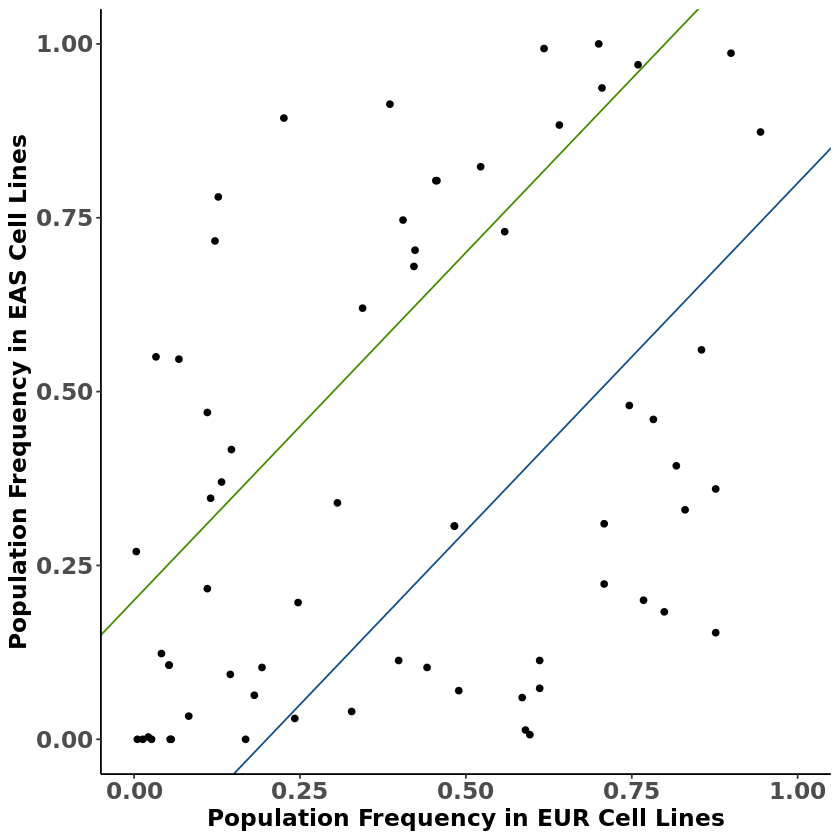

In [142]:
#Bind everything togehter, then plot it.

#Make the matrix
snp.frequency.matrix = snp.level.data.matrix %>%
select(chr, pos, ref, alt) %>%
cbind(., eas.snp.frequency, eur.snp.frequency)


#Make the scatterplot
snp.frequency.matrix %>%
ggplot() +
geom_point(aes(x = eur.snp.frequency, y = eas.snp.frequency)) +
geom_abline(intercept = -0.2, slope = 1, col = "dodgerblue4") +
geom_abline(intercept = 0.2, slope = 1, col = "chartreuse4") +
theme_bw() + 

ylab("Population Frequency in EAS Cell Lines") +
xlab("Population Frequency in EUR Cell Lines") +

theme(panel.border = element_blank(), panel.grid.major = element_blank(),
panel.grid.minor = element_blank(), axis.line = element_line(colour = "black")) +

theme(axis.text=element_text(size=12), axis.title=element_text(size=14,face="bold")) +
theme(axis.text.x = element_text(face="bold", size=14), axis.text.y = element_text(face="bold", size=14)) +

theme(
axis.title.x = element_text(color = "black", size = 14, face = "bold"),
axis.title.y = element_text(color = "black", size = 14, face = "bold")
) +

theme(
axis.text=element_text(size = 12, face = "bold"),
axis.title=element_text(size = 14,face = "bold")
) +

theme(
  legend.title = element_text(size = 14, face = "bold"),
  legend.text = element_text(size = 10, face = "bold")
) +

xlim(c(0,1)) +
ylim(c(0,1))

#Export it to the google bucket
setwd('/home/jupyter/Ancestry/figures')
ggsave("ccle_allele_frequency.pdf", width = 5, height = 5)
system(glue::glue("
cd /home/jupyter/Ancestry/figures
gsutil cp ccle_allele_frequency.pdf gs://fc-45c0e148-0b1c-4244-9bfc-feb559bbc514
"))